# Методы предобучения без учителя, ФКН ВШЭ
## Домашнее задание 4: предобучение звуковых моделей
### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Этот же ноутбук в колабе: [ссылка](https://colab.research.google.com/drive/1kl9yawFSnJbL1KAFouffLwxWT48yoFFB?usp=sharing)
### О задании

В этом домашнем задании мы будет обучать звуковые модели для разных представлений звуковых данных. В качестве датасета возьмем AudioMNIST: в нем 60 спикеров произносят цифры 0-9. Наша основная задача &mdash; классификация цифр, но помимо нее на таких данных мы сможем пощупать голосовую биометрию. 

В этом задании мы не требуем от вас отдельный отчет, но надеемся, что вы грамотно и четко опишете все проводимые вами эксперименты в текстовых ячейках ноутбука. Если проверяющий увидит голые цифры без объяснения и анализа с вашей стороны, то он оставляет за собой право штрафовать вас по своему усмотрению. 

Скачать данные можно с гитхаба:




In [ ]:
!git clone https://github.com/soerenab/AudioMNIST.git

In [1]:
import os
import random
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from IPython.display import Audio

plt.rcParams.update({'font.size': 14})

Далее можете посмотреть пример, как подгружать аудиофайлы с диска, если вы работаете со звуком впервые.

In [2]:
root = 'AudioMNIST/data'
rand_speaker = random.choice(os.listdir(root))
rand_audio = random.choice(os.listdir(os.path.join(root, rand_speaker)))
print(f'Speaker #{rand_speaker}, class #{rand_audio[0]}')

waveform, sample_rate = torchaudio.load(
    os.path.join(root, rand_speaker, rand_audio), normalize=True
)
print(f'Sample rate: {sample_rate}, waveform shape: {waveform.shape}')
Audio(waveform, rate=sample_rate)

Speaker #20, class #0
Sample rate: 48000, waveform shape: torch.Size([1, 34934])


Частота дискретизации в наших данных довольно большая (48кГц), в звуковых моделях обычно достаточно 16кГц, чтобы ускорить процессинг наших аудиодорожек без потери качества. Пересемплировать записи можно следующим образом:

In [3]:
new_sample_rate = 16000
resample = T.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
resampled_waveform = resample(waveform)
Audio(resampled_waveform, rate=new_sample_rate)

Один из популярных способов представить звуковые данные &mdash; перейти к логарифму мел-спектрограммы. На выходе получается картинка, у которой одна размерность отвечает времени, а вторая частотам. Для ускорения обработки можно перенести модуль на GPU (все будет работать, поскольку трансформы наследуются от nn.Module). Также **обратите внимание**, что значения логарифма спектрограммы смещены относительно нуля, так что перед подачей в нейронку имеет смысл нормализовать спектрограмму.

In [4]:
class LogMelSpectrogram(T.MelSpectrogram):
    def __init__(self, eps=1e-8, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def forward(self, waveform):
        return (super().forward(waveform) + self.eps).log()

Spectrogram shape: torch.Size([64, 59])
Values range: ((tensor(-17.6227), tensor(-0.5003)))


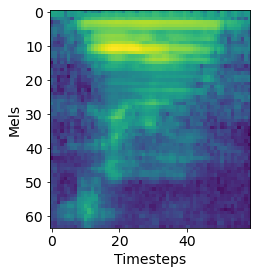

In [5]:
spectrogram = LogMelSpectrogram(sample_rate=16000, n_mels=64)
logmel_spec = spectrogram(resampled_waveform.squeeze())
print(f'Spectrogram shape: {logmel_spec.shape}')
print(f'Values range: ({logmel_spec.min(), logmel_spec.max()})')

plt.imshow(logmel_spec.numpy())
plt.ylabel('Mels')
plt.xlabel('Timesteps')
plt.show()

## Задание 0. Подготовка

**0 баллов**

* Поговорим о разделении данных на обучение и тест. Поскольку мы хотим поэкспериментировать с голосовой биометрией, будет логично разбить данные по спикерам. Отделите треть спикеров в качестве тестовой выборки. Оставшиеся спикеры будут играть роль трейна и валидации. Поделите их в отнощении 80:20. На этот раз не нужно делить данные по спикерам, а лучше сделайте stratified split (как по спикерам, так и по классам внутри спикеров).

* В этом задании мы будем работать с двумя представлениями звуковых данных: как со звуковой дорожкой (waveform), так и с логарифмом мел-спектрограммы. Обрабатывать их предлагается с помощью 1D и 2D сверток, соответственно. Реализуйте две небольшие нейронной сети: одну с 1D энкодером, другую с 2D энкодером. Здесь будет достаточно состакать несколько сверток, поскольку наши данные очень простые и не требуют SOTA архитектур. Рекомендуем брать 1D свертки с dilation, stride и относительно большим размером ядра. 

## Задание 1. Supervised модели

**1 балл**

Обучите отдельно друг от друга 1D энкодер на звуковых дорожках и 2D энкодер на логарифмах спектрограмм на классификацию цифр. В качестве метрики качества используем accuracy. Оцените качество на тестовой выборке.

## Задание 2. Multi-format contrastive learning

**4 балла**

Перейдем к предобучению без разметки. Вам предлагается реализовать метод, контрастирующий эмбеддинги от двух форматов звуковых данных: [статья](https://arxiv.org/abs/2103.06508). Используйте такие же архитектуры энкодеров, как и при обучении supervised моделей. Советуем посмотреть разбор второго ДЗ, чтобы правильно реализовать contrastive loss.

Выберите один тип аугментации для аудиодорожек и один для спектрограмм и обучите 4 разные модели (без аугментаций, только с аугментацией для аудиодорожек, только с аугментацией для спектрограмм и с обоими типами). Замерьте качество линейной пробы тремя способами (только поверх 1D выходов, только поверх 2D выходов и конкатенируя выходы) и выберите лучшую модель по валидации. Ее мы будем использовать в дальнейших экспериментах. Оцените качество на тестовой выборке. 

Чтобы сэкономить время, файнтюнить модели мы не будем и ограничимся только линейной пробой. 

## Задание 3. Визуализация 

**2 балла**

Сейчас в нашем распоряжении 4 модели: по два 1D и 2D энкодера, обученных в supervised и self-supervised манере. Нарисуйте TSNE эмбеддингов тестовой выборки (которую вы отделили в начале задания) для всех 4 моделей. На одном графике в один цвет должны быть покрашены эмбеддинги одного спикера, а на другом &mdash; эмбеддинги для одной цифры. 

## Задание 4. Голосовая биометрия

**3 балла**

Поскольку модель для голосовой биометрии должна уметь обрабатывать новых спикеров, то для решения этой задачи очень часто используют непараметрические классификаторы, такие как kNN.

Попробуем оценить качество голосовой биометрии так: возьмем тестовых спикеров и сгенерируем эмбеддинги их записей с помощью модели. Дальше поделим эмбеддинги на две одинаковые по размеру выборки: на одной будем обучать kNN, а на другой тестировать его. Как и при разделении на трейн и валидацию, нужно сделать stratified split как по спикерам, так и по цифрам.

Подберите оптимальное число соседей k по кросс-валидации на обучающей выборке (имеется в виду выборка, выделенная из теста, а не исходная обучающая) и посчитайте accuracy классификации спикеров для всех 4 моделей. 

## Задание 5. Бонус

**1 балл**

Зафайнтюньте self-supervised модели на классификацию цифр. Сравните качество классификации и голосовой биометрии с supervised моделями и линейной пробой. 